In [27]:
using PyCall
using PyPlot
using CSV, DataFrames
using JLD2
# PyPlot.svg(false)
hp = pyimport("healpy")
nmt = pyimport("pymaster")
nw = pyimport("nawrapper")

PyObject <module 'nawrapper' from '/home/zequnl/anaconda3/envs/ps/lib/python3.7/site-packages/nawrapper-0.1-py3.7.egg/nawrapper/__init__.py'>

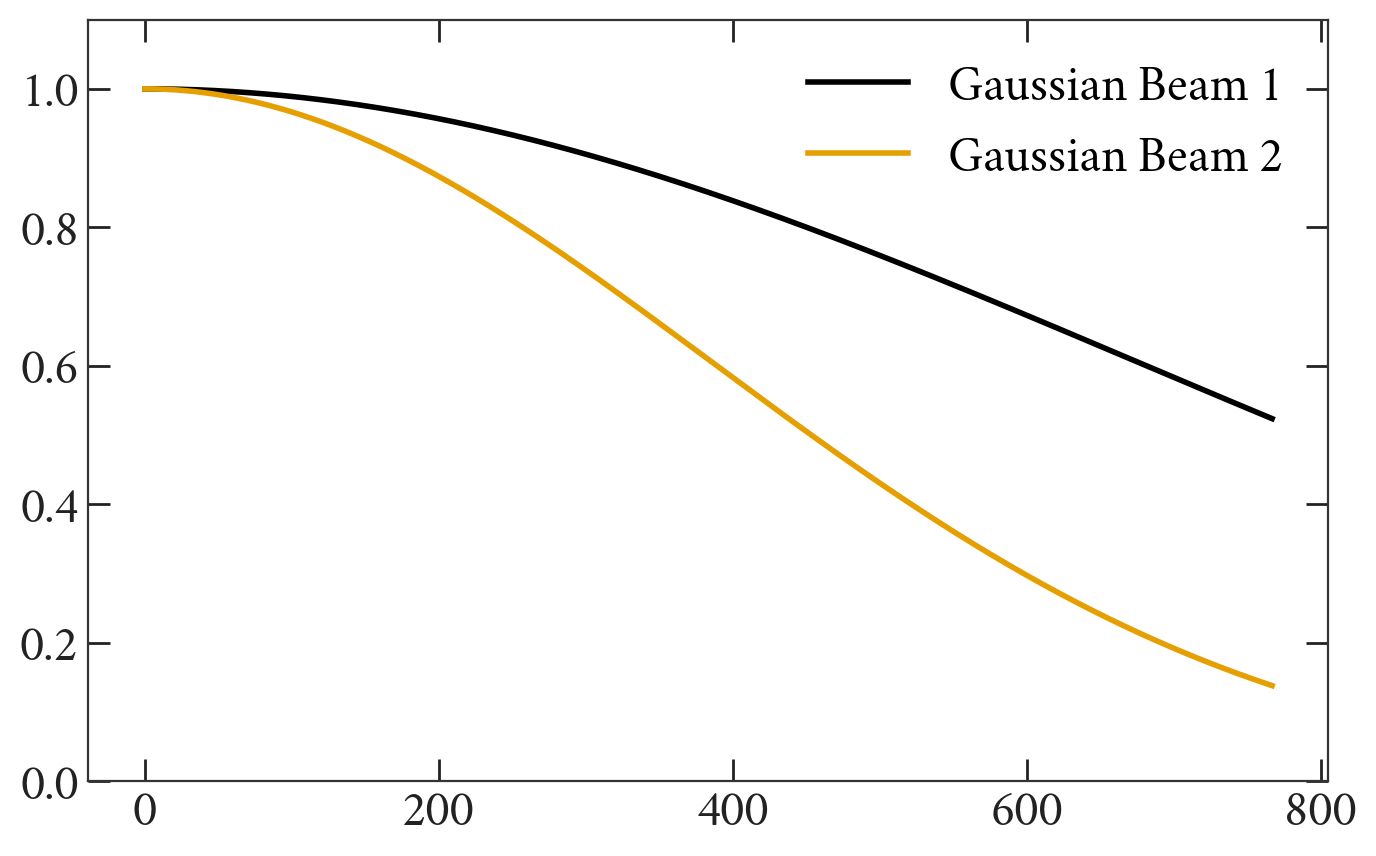

In [28]:
nside = 256
lmax = nside * 3 - 1

B_ell_1 = hp.sphtfunc.gauss_beam(deg2rad(0.2), lmax=lmax)
ell = collect(0:lmax)
plt.plot(ell, B_ell_1, "-", label="Gaussian Beam 1")
plt.ylim(0.0, 1.1)
plt.legend()
beam_df = DataFrame(l=ell, Bl=B_ell_1);
CSV.write("data/beam1.csv", beam_df);

B_ell_2 = hp.sphtfunc.gauss_beam(deg2rad(0.35), lmax=lmax)
ell = collect(0:lmax)
plt.plot(ell, B_ell_2, "-", label="Gaussian Beam 2")
plt.ylim(0.0, 1.1)
plt.legend()
beam_df = DataFrame(l=ell, Bl=B_ell_2);
CSV.write("data/beam2.csv", beam_df);

In [29]:
arr = CSV.read("/home/zequnl/Projects/nawrapper/notebooks/data/example_cls.txt", comment="#", header=false)
theory_df = DataFrame(ell=arr[!,1], cltt=arr[!,2], clte=arr[!,3], clee=arr[!,4], clbb=arr[!,5]);
CSV.write("data/theory.csv", theory_df)

"data/theory.csv"

In [30]:
theory_df.ell

769-element Array{Int64,1}:
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
   ⋮
 757
 758
 759
 760
 761
 762
 763
 764
 765
 766
 767
 768

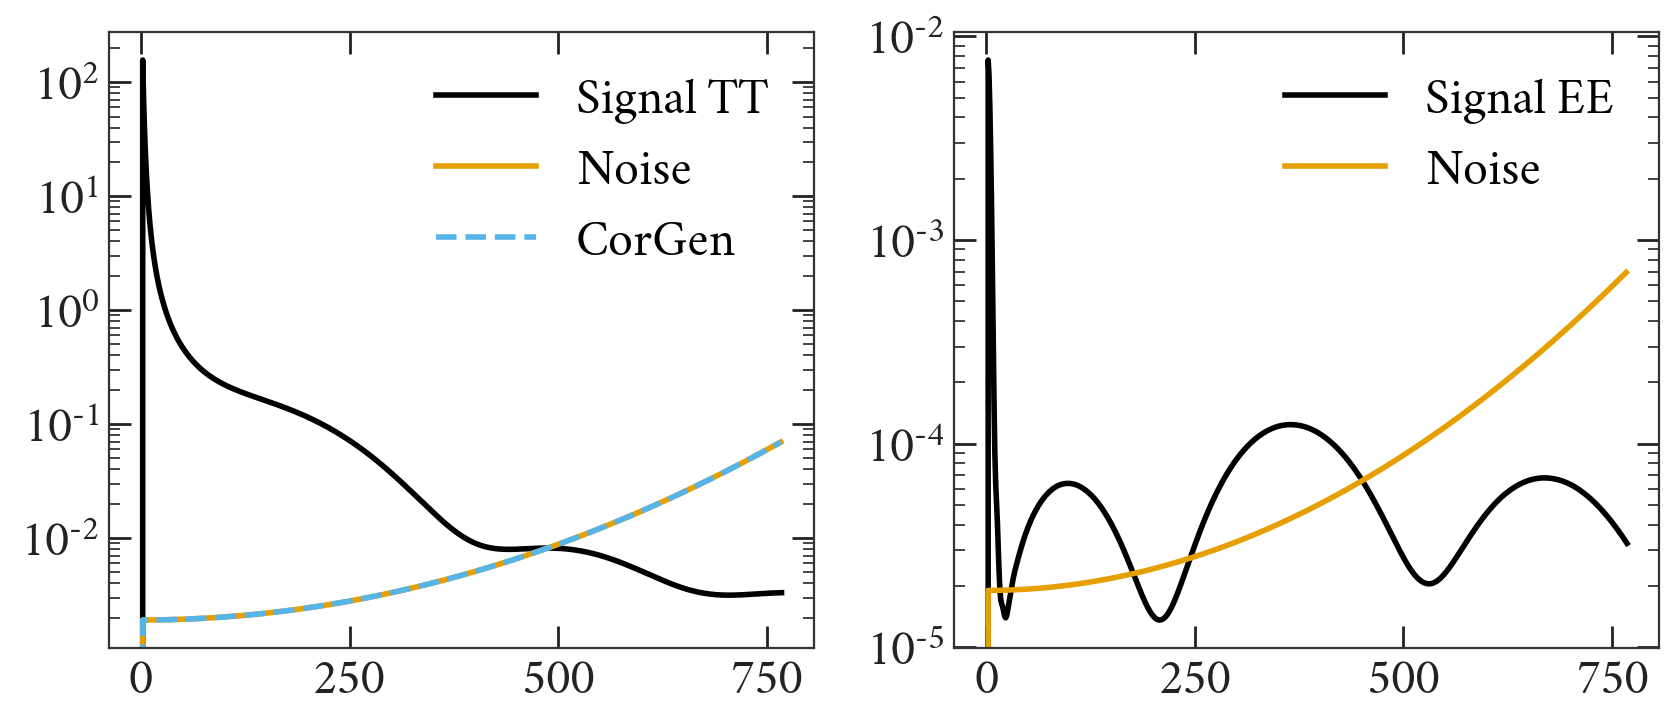

PyObject <matplotlib.legend.Legend object at 0x7feae5aa83d0>

In [31]:
nltt = nw.get_Nl(theta_fwhm=20.0, sigma_T=150, l_max=lmax+1)
nlee = nltt ./ 100
# nl[0:2] = 0.0

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[1].plot(theory_df.cltt, "-", label="Signal TT")
axes[1].plot(nltt, "-", label="Noise")

n0 = 1.5394030890788515 / nside

ell = collect(0:lmax)
factor = nltt .* ell ./ n0

axes[1].plot(n0 ./ ell .* factor, "--", label="CorGen")

axes[1].set_yscale("log")
axes[1].legend()

axes[2].plot(theory_df.clee, "-", label="Signal EE")
axes[2].plot(nlee, "-", label="Noise")
axes[2].set_yscale("log")
axes[2].legend()

In [32]:
noise_df = DataFrame(l=ell, nltt=nltt, nlee=nlee);
CSV.write("data/noise.csv", noise_df)

"data/noise.csv"

In [33]:
using Healpix

mask_arr = zeros(hp.nside2npix(nside))
θ, ϕ = hp.pix2ang(nside, 0:(hp.nside2npix(nside)-1))
ϕ[ϕ .> π] .-= 2π
mask_arr[
    (θ .* (1 .+ 0.1 .* sin.(ϕ .* 3.1 .+ 0.1)) .> 1.7) .|
    (θ .* (1 .+ 0.1 .* sin.(ϕ .* 2.0 .+ 0.1)) .< 1.25)
] .= 1.0 
mask_arr = nmt.mask_apodization(mask_arr, 15.0, apotype="C2")
mask = Map{Float64, RingOrder}(ones(nside2npix(nside)) ) 
mask.pixels .= mask_arr
hp.mollview(mask.pixels, title="Mask 1")
saveToFITS(mask, "!data/mask1.fits")

mask_arr = zeros(hp.nside2npix(nside))
θ, ϕ = hp.pix2ang(nside, 0:(hp.nside2npix(nside)-1))
ϕ[ϕ .> π] .-= 2π
mask_arr[
    (θ .* (1 .+ 0.12 .* sin.(ϕ .* 4.1 .+ 0.15)) .> 1.8) .|
    (θ .* (1 .+ 0.15 .* sin.(ϕ .* 3.6 .+ 0.15)) .< 1.5)
] .= 1.0
mask_arr = nmt.mask_apodization(mask_arr, 15.0, apotype="C2")
mask = Map{Float64, RingOrder}(ones(nside2npix(nside)) ) 
mask.pixels .= mask_arr
hp.mollview(mask.pixels, title="Mask 2")
saveToFITS(mask, "!data/mask2.fits")

In [ ]:
pixwin = true
signal = hp.synfast(theory_df.cltt, 
    nside, verbose=false, pixwin=pixwin, new=true)
n1 = hp.synfast(nltt, 
    nside, verbose=false, pixwin=pixwin, new=true)
n2 = hp.synfast(nltt, 
    nside, verbose=false, pixwin=pixwin, new=true)
map1 = Map{Float64, RingOrder}(nside)
map1.pixels .= hp.sphtfunc.smoothing(signal .+ n1, beam_window=B_ell_1)
map2 = Map{Float64, RingOrder}(nside)
map2.pixels .= hp.sphtfunc.smoothing(signal .+ n2, beam_window=B_ell_2)

saveToFITS(map1, "!data/m1.fits")
saveToFITS(map2, "!data/m2.fits")

In [ ]:
hp.mollview(map1.pixels, title="simulated map")

In [12]:
flat = ones(hp.nside2npix(nside))

hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= flat;
saveToFITS(hp_m, "!data/weight1.fits")
saveToFITS(hp_m, "!data/weight2.fits")